# Make fake flat, LFC, and science exposures to train a CNN?

## Author:
- **David W Hogg** (NYU)

## Bugs:
- Insanely slow. Could be sped up (probably) with `jax.vmap`.
- No telluric lines.
- No bias or sky level.
- Cosmic rays are too trivial.

In [1]:
import numpy as np
import pylab as plt
%matplotlib inline

In [2]:
# Revise default plotting style
style_revisions = {
            'axes.linewidth': 1.5,
            'xtick.top' : True, 
            'ytick.right' : True, 
            'xtick.direction' : 'in',
            'ytick.direction' : 'in', 
            'xtick.major.size' : 11, 
            'ytick.major.size' : 11, 
            'xtick.minor.size' : 5.5, 
            'ytick.minor.size' : 5.5,
            'font.size' : 16,
            'figure.figsize' : [12, 6],
            'lines.linewidth' : 2.5,
        }
plt.rcParams.update(style_revisions)

In [3]:
# Set defaults.
rng = np.random.default_rng(17)
TWOPI = 2. * np.pi
ONEOVERTWOPI = 1. / TWOPI

In [4]:
# Define useful functions.
def gaussian_2d(xxs, yys, mean, var):
    """
    `xxs`   should be shape `(nx, ny)`.
    `yys`   should be shape `(nx, ny)`.
    `mean`  should be shape `(2, )`.
    `var`   should be a scalar.
    """
    return ONEOVERTWOPI / var \
           * np.exp(-0.5 / var * ((xxs - mean[0]) ** 2 + (yys - mean[1]) ** 2))
def gaussian_1d(xxs, mean, var):
    """
    `xxs`   should be shape `(nx, )`.
    `mean`  should be a scalar.
    `var`   should be a scalar.
    """
    return np.sqrt(ONEOVERTWOPI / var) \
           * np.exp(-0.5 / var * (xxs - mean) ** 2)

In [5]:
Nx = 512
Ny = 128

In [6]:
# Make true 1D spectrum.
linexs = - Nx // 2 + 2 * Nx * rng.uniform(size=256)
depths = 5. * rng.uniform(size=len(linexs)) ** 4

In [7]:
# Define trace and the non-orthogonality of the wavelength solution.
def trace(xs):
    return 107.5 - 0.0002 * (xs - 500.3) ** 2
def dxdy(xs):
    return - 0.0006 * (xs - 500.3)

In [8]:
# Make true flat spots.
xspots = np.arange(-5., Nx + 5.01, 1.)
yspots = np.arange(-5., 5.01, 1.)

# Make true LFC spots.
lfcspots = np.arange(-20., Nx + 20.01, 5. * np.pi)

In [9]:
# Make pixel-level flat
pixel_flat = 1. + 0.05 * rng.normal(size=(Ny, Nx))
pixel_flat += 0.05 * np.ones(Ny)[:, None] * rng.normal(size=Nx)[None, :]
pixel_flat = np.clip(pixel_flat, 0., None)

In [10]:
def make_flat_lfc_science():
    """
    ## bugs:
    - Everything is hard coded and magic.
    - Relies on global variables.
    """
    # Make Doppler shift
    dx = 60. * rng.uniform() - 30.

    # Make calibration offsets
    ddx, ddy = 1. - 2. * rng.uniform(size=2)

    # Make pixel grids for a tiny image section
    xs = np.arange(Nx).astype(float) + ddx
    ys = np.arange(Ny).astype(float) + ddy
    xxs, yys = np.meshgrid(xs, ys)

    # Make true flat by an agonizing process
    var = 1.
    trueflat = np.zeros_like(xxs).astype(float)
    for x in xspots:
        for y in yspots:
            trueflat += gaussian_2d(xxs, yys, [x + dxdy(x) * y, trace(x) + y], var)
    
    # Make true LFC by a similarly agonizing process
    specvar = 5. # pixels ** 2
    truelfc = np.zeros_like(xxs).astype(float)
    for x in lfcspots:
        for y in yspots:
            truelfc += 4. * gaussian_2d(xxs, yys, [x + dxdy(x) * y, trace(x) + y], specvar)

    # Make true science image by multiplying the flat
    foo = np.zeros_like(xxs)
    for x, d in zip(linexs + dx, depths):
        foo -= d * gaussian_1d(xxs - dxdy(xxs) * (yys - trace(xxs)), x, specvar)
    truesci = trueflat * np.exp(foo)

    # Multiply all three by the pixel-level flat
    trueflat *= pixel_flat
    truelfc *= pixel_flat
    truesci *= pixel_flat

    # Add gaussian noise to simulate shot noise
    flat = trueflat + 0.04 * np.sqrt(trueflat) * rng.normal(size=xxs.shape)
    lfc  = truelfc  + 0.01 * np.sqrt(truelfc)  * rng.normal(size=xxs.shape)
    sci  = truesci  + 0.05 * np.sqrt(truesci)  * rng.normal(size=xxs.shape)

    # Add (stupid) cosmic rays
    flat += rng.uniform(size=xxs.shape) < 0.01
    lfc  += rng.uniform(size=xxs.shape) < 0.01
    sci  += rng.uniform(size=xxs.shape) < 0.01

    return dx, flat, lfc, sci

In [11]:
def make_training_data(N):
    for n in range(N):
        dx, flat, lfc, sci = make_flat_lfc_science()
        if n == 0:
            y = np.zeros(N)
            x = np.zeros((N, ) + flat.shape + (3, ))
        print(n, dx)
        y[n] = dx
        x[n] = np.concatenate((flat[:, :, None], lfc[:, :, None],
                               sci[:, :, None]), axis=-1)
    return x, y

In [12]:
test, _ = make_training_data(1)

0 8.131669175337258


Text(0, 0.5, '$y$ (pix)')

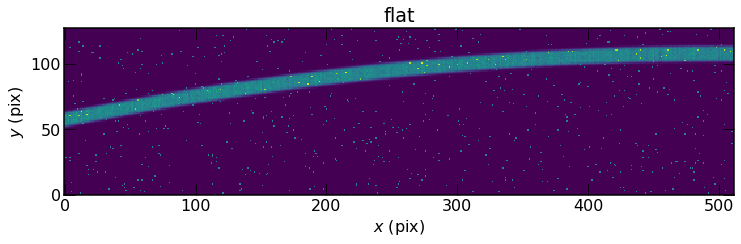

In [13]:
imshowkwargs = {"origin": "lower", "interpolation": "nearest"}
plt.title("flat")
plt.imshow(test[0, :, :, 0], **imshowkwargs)
plt.xlim(-0.5, Nx - 0.5)
plt.xlabel(r"$x$ (pix)")
plt.ylabel(r"$y$ (pix)")

Text(0, 0.5, '$y$ (pix)')

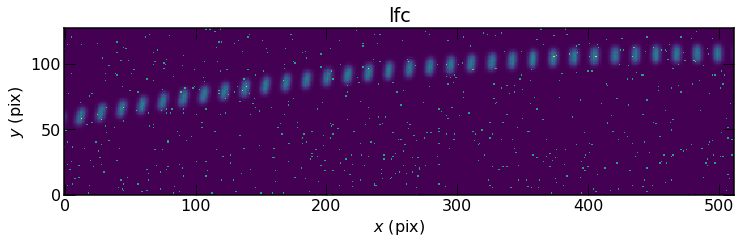

In [14]:
imshowkwargs = {"origin": "lower", "interpolation": "nearest"}
plt.title("lfc")
plt.imshow(test[0, :, :, 1], **imshowkwargs)
plt.xlim(-0.5, Nx - 0.5)
plt.xlabel(r"$x$ (pix)")
plt.ylabel(r"$y$ (pix)")

Text(0, 0.5, '$y$ (pix)')

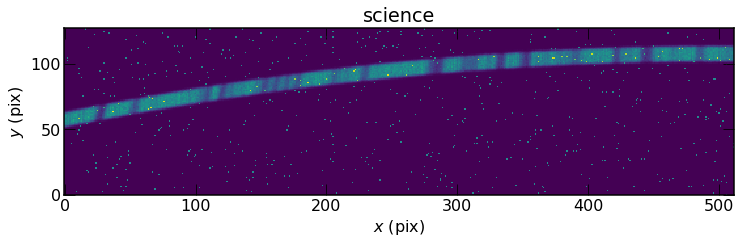

In [15]:
imshowkwargs = {"origin": "lower", "interpolation": "nearest"}
plt.title("science")
plt.imshow(test[0, :, :, 2], **imshowkwargs)
plt.xlim(-0.5, Nx - 0.5)
plt.xlabel(r"$x$ (pix)")
plt.ylabel(r"$y$ (pix)")

In [16]:
# Now make lots of training data.
xs_train, ys_train = make_training_data(100)
print(xs_train.shape, ys_train.shape)

0 -23.766744399783487
1 -20.593506552291462
2 -27.503203129130565
3 15.355188979315194
4 14.817210083951167
5 26.065230164145547
6 -18.238119077221526
7 24.165848328548037
8 16.738191003819892
9 7.7544237355632575
10 6.033253090798155
11 16.324930434863745
12 -19.823919752255392
13 15.436628664612705
14 -13.39956027193577
15 28.37250994713485
16 21.67806014365309
17 -3.337657276496735
18 -5.98977864856878
19 -3.39858603308976
20 0.9088785090314673
21 -9.096442966742849
22 28.970474789298294
23 -28.539155068255752
24 9.956264511878473
25 5.636591581481035
26 10.807356331708817
27 4.6511959608905755
28 2.655459064131712
29 2.770726167425032
30 -27.365504879958877
31 14.830052735946083
32 -1.674734682533071
33 23.176731972450987
34 16.66835044761382
35 -1.7519258836572114
36 11.663133926494993
37 17.558304723828186
38 2.67780947008265
39 -6.611122345539023
40 -29.138644891021194
41 -14.786193110791562
42 4.628224569375043
43 -22.269616805657037
44 20.188121274677698
45 -2.6335254883179076

In [17]:
xs_valid, ys_valid = make_training_data(25)
print(xs_valid.shape, ys_valid.shape)

0 28.428382585802346
1 -19.530841809743766
2 6.351973090519479
3 -20.745037159702157
4 27.793639167067106
5 19.497473100921894
6 -20.262658621277907
7 -15.8548425737871
8 -21.76991332146305
9 -4.883302703198822
10 -20.798465287257017
11 -29.193724841428306
12 -24.51539736838878
13 -21.98045488076059
14 -27.33450100089555
15 -1.740375213192678
16 11.272565260060624
17 -21.67816910444529
18 1.4278166804852468
19 -8.267475836366717
20 29.81590845385397
21 -12.389635039542185
22 -28.23607632625162
23 -17.64833003872272
24 1.810730850720276
(25, 128, 512, 3) (25,)


In [18]:
xs_test, ys_test = make_training_data(25)
print(xs_test.shape, ys_test.shape)

0 8.241354474836328
1 -29.570560288719353
2 1.3160655337074765
3 -0.22814992636025622
4 -18.265802262293917
5 25.250305843452708
6 -17.63465723029943
7 14.982524661000149
8 5.1351401843270565
9 -24.76624988905469
10 -29.129482193467922
11 13.28899989845965
12 15.02061562749956
13 -15.63992686726898
14 16.669260203869477
15 2.221279828822503
16 17.283881103505323
17 7.1985504022555915
18 23.777019549972366
19 10.195820886720142
20 7.8140820546629755
21 -19.69925241011094
22 22.07680274136397
23 -5.189354709903217
24 -28.01638545675947
(25, 128, 512, 3) (25,)


In [19]:
import pickle

In [20]:
def save_data(filename,obj):
  with open(filename, 'wb') as handle:
    pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
save_data('../data/xs_train.pickle',xs_train)
save_data('../data/ys_train.pickle',ys_train)
save_data('../data/xs_valid.pickle',xs_valid)
save_data('../data/ys_valid.pickle',ys_valid)

In [22]:
import sys
print(sys.path)

['/Users/matthewdaunt/Documents/pythons/wobble_full/repos/CNN_RVs/example', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python37.zip', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/lib-dynload', '', '/Users/matthewdaunt/Library/Python/3.7/lib/python/site-packages', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyFluidSynth-1.2.5-py3.7.egg', '/Users/matthewdaunt/Documents/pythons/networks/gym', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Robinhood-1.0.1-py3.7.egg', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/six-1.11.0-py3.7.egg', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/requests-2.18.4-py3.7.egg', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packag

In [23]:
def load_data(filename):
  with open(filename, 'rb') as handle:
    obj = pickle.load(handle)
    return obj

Comment in once data has been simulated

In [24]:
# xs_train = load_data('../data/xs_train.pickle')
# ys_train = load_data('../data/ys_train.pickle')
# xs_valid = load_data('../data/xs_valid.pickle')
# ys_valid = load_data('../data/ys_valid.pickle')